<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/text-similarity-works/21_keyword_semantic_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Keyword Semantic Search

In [ ]:
!pip install sentence_transformers
!pip install nmslib
!pip install ipdb

In [2]:
from sentence_transformers import SentenceTransformer, CrossEncoder
from sentence_transformers import util

import spacy
from spacy.matcher import Matcher

import nmslib

#from outdoors import *
#from plotnine import *

import pandas as pd
import pickle
import json
import re
import tqdm
from IPython.display import display,HTML
pd.set_option('display.max_rows', 1000)

##Load Dataset

In [3]:
icd_9_df = pd.read_csv('icd_9_code_and_kerwords.csv')
icd_9_df.head()

,Code,Keyword
0,001.0,Cholera due to vibrio cholerae
1,001.1,Cholera due to vibrio cholerae el tor
2,001.9,Cholera unspecified
3,002.0,Typhoid fever
4,002.1,Paratyphoid fever A


In [4]:
print(len(icd_9_df))

18449


In [5]:
icd_10_df = pd.read_csv('icd_10_code_and_keywords_v3.csv')
icd_10_df.head()

,Code,Keyword,SynId,Field_Target
0,S60.879,Other superficial bite of unspecified wrist,INJ11,Wound_Type
1,S60.879A,"Other superficial bite of unspecified wrist, i...",INJ11,Wound_Type
2,S60.879D,"Other superficial bite of unspecified wrist, s...",INJ11,Wound_Type
3,S60.879S,"Other superficial bite of unspecified wrist, s...",INJ11,Wound_Type
4,S60.9,"Unspecified superficial injury of wrist, hand ...",INJ3,Injury_Location


In [6]:
len(icd_10_df)

96745

In [7]:
icd_keywords_df = pd.concat([icd_9_df, icd_10_df])
icd_keywords_df.head()

,Code,Keyword,SynId,Field_Target
0,001.0,Cholera due to vibrio cholerae,NaN,NaN
1,001.1,Cholera due to vibrio cholerae el tor,NaN,NaN
2,001.9,Cholera unspecified,NaN,NaN
3,002.0,Typhoid fever,NaN,NaN
4,002.1,Paratyphoid fever A,NaN,NaN


In [8]:
(18449 + 96745)

115194

In [9]:
len(icd_keywords_df)

115194

##Loading model

In [ ]:
stsb = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

In [11]:
print(stsb)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': True}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)


##Getting Embeddings

In [12]:
icd_keywords_embeddings_pickle = "icd_keywords_embeddings.pickle"

In [13]:
def get_embeddings(sentences, load_from_cache=True):
  if not load_from_cache:
    embeddings = stsb.encode(sentences, convert_to_tensor=True)
    with open(icd_keywords_embeddings_pickle, "wb") as fd:
      pickle.dump(embeddings, fd)
  else:
    with open(icd_keywords_embeddings_pickle, "rb") as fd:
      embeddings = pickle.load(fd)
  return embeddings

In [14]:
# Encode the keywords into embeddings
keywords = list(filter(None, list(icd_keywords_df["Keyword"])))
embeddings = get_embeddings(keywords, load_from_cache=False).cpu().numpy()

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 115194
Dimensions per embedding: 768


##Calculate similarity

In [ ]:
# let's find the pairs with the highest cosine similarity scores
similarities = util.pytorch_cos_sim(embeddings[0:100], embeddings[0:100])
print(f"The shape of the resulting similarities: {similarities.shape}")

The shape of the resulting similarities: torch.Size([100, 100])


In [ ]:
a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities) - 1):
  for b in range(a + 1, len(similarities)):
    a_phrases.append(keywords[a])
    b_phrases.append(keywords[b])
    scores.append(float(similarities[a][b]))

comparisons_df = pd.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score": scores})
comparisons_df = comparisons_df.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons_df[comparisons_df["score"] > .9]

,phrase a,phrase b,score
0,Paratyphoid fever A,Paratyphoid fever C,0.982230
1,Intestinal infection due to enteropathogenic E...,Intestinal infection due to enterotoxigenic E....,0.980808
2,Primary tuberculous infection tubercle bacilli...,Other primary progressive tuberculosis tubercl...,0.973134
3,Intestinal infection due to enteropathogenic E...,Intestinal infection due to enteroinvasive E. ...,0.966536
4,Intestinal infection due to enterotoxigenic E....,Intestinal infection due to enteroinvasive E. ...,0.961821
5,Paratyphoid fever B,Paratyphoid fever C,0.953545
6,Paratyphoid fever A,Paratyphoid fever B,0.952772
7,Primary tuberculous infection tubercle bacilli...,Tuberculous pleurisy in primary progressive tu...,0.952296
8,Tuberculous pleurisy in primary progressive tu...,Other primary progressive tuberculosis tubercl...,0.947442
9,Primary tuberculous infection tubercle bacilli...,Other primary progressive tuberculosis tubercl...,0.946956


##Nearest-Neighbor search

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [15]:
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method="hnsw", space="cosinesimil")
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

In [16]:
keywords[25]

'Botulism food poisoning'

In [17]:
# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [keywords[idx] for idx in ids]
print(matches)

['Botulism food poisoning', 'Botulism food poisoning', 'Other bacterial food poisoning', 'Toxic effect of mycotoxin food contamnt, assault, sequela', 'Toxic effect of mycotoxin food contamnt, acc, sequela', 'Food in bronchus causing asphyxiation, sequela', 'Toxic effect of mycotoxin food contamnt, self-harm, sequela', 'Poisoning by oth bacterial vaccines, accidental', 'Benign carcinoid tumor of the stomach', 'Benign carcinoid tumor of the stomach']


In [18]:
keywords[21]

'Shigella sonnei'

In [19]:
# Example query for the new index.  The 21th embedding is the term 'work'
ids, distances = index.knnQuery(embeddings[21], k=10)
matches = [keywords[idx] for idx in ids]
print(matches)

['Shigella sonnei', 'Shigellosis due to Shigella sonnei', 'Shigellosis', 'Shigellosis, unspecified', 'Shigella flexneri', 'Shigella boydii', 'Shigellosis due to Shigella flexneri', 'Shigella dysenteriae', 'Shigellosis unspecified', 'Other shigellosis']


In [20]:
def print_labels(prefix, matches):
  display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
  for l,d in matches:
    print(str(int(d*1000)/1000), '|', l)

In [21]:
# let's create a method that accepts any query whether or not it’s already in our dictionary
def semantic_search(query, k=20, minimum_similarity=0.6):
  matches = []
  embeddings = stsb.encode([query], convert_to_tensor=True)
  ids, distances = index.knnQuery(embeddings[0].cpu().numpy(), k=k)
  for id in range(len(ids)):
    text = keywords[ids[id]]
    distance = 1.0 - distances[id]
    if distance > minimum_similarity:
      matches.append((text, distance))
  if not len(matches):
    matches.append((keywords[ids[1]], 1.0 - distances[1]))
  print_labels(query, matches)

In [22]:
semantic_search("shigella sonnei")

1.0 | Shigella sonnei
0.744 | Shigellosis due to Shigella sonnei
0.664 | Shigellosis
0.63 | Shigellosis, unspecified
0.626 | Shigella flexneri
0.623 | Shigella boydii
0.618 | Shigellosis due to Shigella flexneri


In [23]:
embeddings.shape

(115194, 768)

In [24]:
semantic_search("Hypertriglyceridemia, sporadic")

0.636 | Hypertrichosis of left eye, unspecified eyelid
0.634 | Hypertrichosis of unspecified eye, unspecified eyelid
0.626 | Hypertrichosis of right eye, unspecified eyelid
0.625 | Localized hypertrichosis
0.622 | Hypertrichosis of left lower eyelid
0.61 | Attention deficit disorder with hyperactivity
0.606 | Hypertrichosis of eyelid
0.606 | Hypertrichosis of eyelid


In [25]:
semantic_search("Routine general medical examination at a health care facility, Hypertriglyceridemia, sporadic")

0.734 | Routine general medical examination at a health care facility
0.607 | Laboratory examination ordered as part of a routine general medical examination
0.602 | Complication of vein following a procedure, NEC


In [26]:
semantic_search("Fever")

0.55 | Fatigue fracture of vertebra, cervical region


In [27]:
semantic_search("Folliculitis")

0.796 | Folliculitis decalvans
0.72 | Fasciolopsiasis
0.72 | Fasciolopsiasis
0.684 | Follicular lymphoma
0.671 | Fascioliasis
0.671 | Fascioliasis
0.656 | Diffuse (eosinophilic) fasciitis
0.642 | Pneumococcal polyarthritis
0.64 | Diffuse follicle center lymphoma
0.638 | Chronic follicular conjunctivitis
0.638 | Chronic follicular conjunctivitis
0.633 | Unsp maternal infec/parastc disease comp the puerperium
0.633 | Irritant contact dermatitis related to unsp stoma or fistula
0.632 | Viral pharyngoconjunctivitis
0.629 | Follicular lymphoma grade I
0.628 | Pneumococcal peritonitis
0.626 | Herpesviral vulvovaginitis
0.625 | Acute follicular conjunctivitis
0.625 | Acute follicular conjunctivitis
0.621 | Irritant contact dermatitis related to resp stoma or fistula


In [28]:
semantic_search("Sinusitis, acute, maxillary")

0.779 | Acute maxillary sinusitis
0.779 | Acute maxillary sinusitis
0.759 | Chronic maxillary sinusitis
0.759 | Chronic maxillary sinusitis
0.757 | Acute recurrent maxillary sinusitis
0.733 | Seminal vesiculitis
0.701 | Superficial (capsular) laceration of spleen, sequela
0.701 | Malignant neoplasm of maxillary sinus
0.701 | Malignant neoplasm of maxillary sinus
0.699 | Acute sinusitis
0.699 | Acute sphenoidal sinusitis
0.699 | Acute sphenoidal sinusitis
0.698 | Acute frontal sinusitis
0.698 | Acute frontal sinusitis
0.69 | Superficial (capsular) laceration of spleen
0.689 | Superficial (capsular) laceration of spleen, subs encntr
0.688 | Acute recurrent sphenoidal sinusitis
0.678 | Acute maxillary sinusitis, unspecified
0.672 | Other acute sinusitis
0.672 | Other acute sinusitis


##Keyword similarity

In [29]:
# let's create a method that accepts any query whether or not it’s already in our dictionary
def semantic_search(query, k=5, minimum_similarity=0.6):
  matches = []
  match_dict = {}
  embeddings = stsb.encode([query], convert_to_tensor=True)
  ids, distances = index.knnQuery(embeddings[0].cpu().numpy(), k=k)
  for id in range(len(ids)):
    text = keywords[ids[id]]
    distance = 1.0 - distances[id]
    if distance > minimum_similarity:
      matches.append((text, distance))
  if len(matches) > 0:
    matches.append((keywords[ids[1]], 1.0 - distances[1]))
    match_dict = {
        "keyword": keywords[ids[0]],
        "score": 1.0 - distances[0]
    }
    #print_labels(query, matches)
  return match_dict

In [30]:
def clean_file(file_path):
    rx = re.compile(r'\b\w*?([a-z])\1\1\w*\b', re.IGNORECASE)
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        out_list = []
        for line in lines:
            cleaned = re.sub('[@_!#$%^&*()<>?}{~:\\d>»\/|—\-\[\]]*', '', line.strip())
            cleaned = re.sub(r"(.)\1{2,}", " ", cleaned)
            cleaned = re.sub(r" {2,}", " ", cleaned)
            out_list.append(cleaned.strip())
    return [line for line in out_list if line.strip()]

In [31]:
keyword_list = set(clean_file("page-7.txt"))
#keyword_list

In [32]:
for keyword in keyword_list:
  match_dict = semantic_search(keyword)
  if match_dict:
    print(keyword)
    print(f"\t {match_dict}")

Diagnosis Hypertriglyceridemia, sporadic E.
	 {'keyword': 'Absence epileptic syndrome, intractable, w/o stat epi', 'score': 0.6227527856826782}
COVID Rapid Test Positive Abn A Final,
	 {'keyword': 'Cervical high risk HPV DNA test positive', 'score': 0.6555649042129517}
Diagnosis Contact with and suspected exposure to COVID Z.
	 {'keyword': 'Contact with and (suspected) exposure to Zika virus', 'score': 0.6194724440574646}
Diagnosis Cough R.
	 {'keyword': 'Chronic cough', 'score': 0.7892540693283081}
Lab Reviewed COVID Rapid Test Accession
	 {'keyword': 'Encntr for fit/adjst of dev rel to nrv sys and specl senses', 'score': 0.6097027659416199}
COVID Rapid Test Negative Reavionied
	 {'keyword': 'Extravasation of vesicant agent', 'score': 0.6153018474578857}


##Re-ranking

In [ ]:
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
icd_keywords_embeddings_pickle2 = "icd_keywords_embeddings2.pickle"

def get_embeddings(sentences, load_from_cache=True):
  if not load_from_cache:
    embeddings = bi_encoder.encode(sentences, convert_to_tensor=True)
    with open(icd_keywords_embeddings_pickle2, "wb") as fd:
      pickle.dump(embeddings, fd)
  else:
    with open(icd_keywords_embeddings_pickle2, "rb") as fd:
      embeddings = pickle.load(fd)
  return embeddings

In [ ]:
# Encode the keywords into embeddings
keywords = list(filter(None, list(icd_keywords_df["Keyword"])))
keyword_embeddings = get_embeddings(keywords, load_from_cache=False).cpu().numpy()

print(f"Number of embeddings: {len(keyword_embeddings)}")
print(f"Dimensions per embedding: {len(keyword_embeddings[0])}")

Number of embeddings: 115194
Dimensions per embedding: 384


In [ ]:
top_k = 32

def search(query):
    print("\n#################################\n")
    print("Input query:", query)

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    query_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    query_embedding = query_embedding.cuda()
    hits = util.semantic_search(query_embedding, keyword_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, keywords[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-3 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:3]:
      if hit['score'] > .50:
        print("\t{:.3f}\t{}".format(hit['score'], keywords[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-3 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:3]:
      #if hit['cross-score'] > .50:
      print("\t{:.3f}\t{}".format(hit['cross-score'], keywords[hit['corpus_id']].replace("\n", " ")))

In [ ]:
keyword_list = set(clean_file("page-7.txt"))
# keyword_list

In [ ]:
for keyword in keyword_list:
  search(query=keyword)

#search(query = "What is the capital of the United States?")

In [ ]:
search(query = "Diagnosis Cough")


#################################

Input query: Diagnosis Cough

-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.871	Cough
	0.871	Cough
	0.841	Chronic cough

-------------------------

Top-3 Cross-Encoder Re-ranker hits
	-0.370	Whooping cough due to Bordetella pertussis with pneumonia
	-0.557	Whooping cough due to bordetella parapertussis [B. parapertussis]
	-0.640	Whooping cough due to bordetella pertussis [B. pertussis]


In [ ]:
search(query = "Diagnosis Hypertriglyceridemia, sporadic")


#################################

Input query: Diagnosis Hypertriglyceridemia, sporadic

-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.706	Diabetes due to underlying condition w hyperglycemia
	0.704	Pure hyperglyceridemia
	0.704	Pure hyperglyceridemia

-------------------------

Top-3 Cross-Encoder Re-ranker hits
	-2.490	Pure hyperglyceridemia
	-2.490	Pure hyperglyceridemia
	-3.734	Hyperglycemia, unspecified


In [ ]:
search(query = "Diagnosis Contact with and suspected exposure to COVID")


#################################

Input query: Diagnosis Contact with and suspected exposure to COVID

-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.874	Contact with and (suspected) exposure to COVID-19
	0.676	Encounter for screening for COVID-19
	0.600	Contact w and (suspected) exposure to communicable diseases

-------------------------

Top-3 Cross-Encoder Re-ranker hits
	6.809	Contact with and (suspected) exposure to COVID-19
	-0.058	Contact with and (suspected) exposure to other potentially hazardous substances
	-0.131	Contact with and (suspected) exposure to other potentially hazardous chemicals


In [ ]:
def search(queries):
    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    query_embedding = bi_encoder.encode(queries, convert_to_tensor=True)
    query_embedding = query_embedding.cuda()
    all_hits = util.semantic_search(query_embedding, keyword_embeddings, top_k=top_k)
    #hits = hits[0]  # Get the hits for the first query
    # import ipdb; ipdb.set_trace() # debugging starts here

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    for hits in all_hits:
      print("\n#################################\n")
      for id, query in enumerate(queries):
        print("\nInput query:", query)
        cross_inp = [[query, keywords[hit['corpus_id']]] for hit in hits]
        cross_scores = cross_encoder.predict(cross_inp)

        # Sort results by the cross-encoder scores
        for idx in range(len(cross_scores)):
          hits[idx]['cross-score'] = cross_scores[idx]

        # Output of top-5 hits from bi-encoder
        print("\n-------------------------\n")
        print("Top-3 Bi-Encoder Retrieval hits")
        hits = sorted(hits, key=lambda x: x['score'], reverse=True)
        for hit in hits[0:1]:
          if hit['score'] > .50:
            print("\t{:.3f}\t{}".format(hit['score'], keywords[hit['corpus_id']].replace("\n", " ")))

        # Output of top-5 hits from re-ranker
        print("\n-------------------------\n")
        print("Top-3 Cross-Encoder Re-ranker hits")
        hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
        for hit in hits[0:1]:
          #if hit['cross-score'] > .50:
          print("\t{:.3f}\t{}".format(hit['cross-score'], keywords[hit['corpus_id']].replace("\n", " ")))

In [ ]:
queries = [
    "Diagnosis Contact with and suspected exposure to COVID",
    "Diagnosis Cough",
    "Diagnosis Hypertriglyceridemia, sporadic"
]
search(queries)

##Page-wise search

In [ ]:
encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [41]:
keyword_list = clean_file("page-7.txt")

corpus_embeddings = encoder.encode(keyword_list, convert_to_tensor=True)

# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method="hnsw", space="cosinesimil")
index.addDataPointBatch(corpus_embeddings.cpu().numpy())
index.createIndex(print_progress=True)

In [62]:
# let's create a method that accepts any query whether or not it’s already in our dictionary
def semantic_search(query, k=5, minimum_similarity=0.5):
  matches = []
  embeddings = encoder.encode([query], convert_to_tensor=True)
  ids, distances = index.knnQuery(embeddings[0].cpu().numpy(), k=k)
  for id in range(len(ids)):
    text = keyword_list[ids[id]]
    distance = 1.0 - distances[id]
    if distance > minimum_similarity:
      matches.append((text, distance))
  if not len(matches):
    matches.append((keyword_list[ids[1]], 1.0 - distances[1]))
  print_labels(query, matches)

In [63]:
# Z20.822, Contact with and (suspected) exposure to COVID-19
semantic_search("Contact with and (suspected) exposure to COVID-19")

0.802 | Diagnosis Contact with and suspected exposure to COVID Z.
0.506 | Lab Reviewed COVID Rapid Test Accession
0.506 | Lab Reviewed COVID Rapid Test Accession


In [64]:
# R05.9, Cough, unspecified
semantic_search("Cough, unspecified")

0.655 | Diagnosis Cough R.


In [65]:
# E78.3, Hyperchylomicronemia
semantic_search("Hyperchylomicronemia")

0.291 | Diagnosis Contact with and suspected exposure to COVID Z.


In [66]:
# let's create a method that accepts any query whether or not it’s already in our dictionary
def semantic_search(query, k=5, minimum_similarity=0.6):
  matches = []
  match_dict = {}
  embeddings = encoder.encode([query], convert_to_tensor=True)
  ids, distances = index.knnQuery(embeddings[0].cpu().numpy(), k=k)
  for id in range(len(ids)):
    text = keyword_list[ids[id]]
    distance = 1.0 - distances[id]
    if distance > minimum_similarity:
      matches.append((text, distance))
  if len(matches) > 0:
    matches.append((keyword_list[ids[1]], 1.0 - distances[1]))
    match_dict = {
        "keyword": keyword_list[ids[0]],
        "score": 1.0 - distances[0]
    }
    #print_labels(query, matches)
  return match_dict

In [67]:
# Z20.822, Contact with and (suspected) exposure to COVID-19
semantic_search("Contact with and (suspected) exposure to COVID-19")

{'keyword': 'Diagnosis Contact with and suspected exposure to COVID Z.',
 'score': 0.8027372360229492}

In [68]:
# R05.9, Cough, unspecified
semantic_search("Cough, unspecified")

{'keyword': 'Diagnosis Cough R.', 'score': 0.6556733846664429}

In [69]:
# E78.3, Hyperchylomicronemia
semantic_search("Hyperchylomicronemia")

{}

In [72]:
keyword_list = clean_file("page-7.txt")
corpus_embeddings = encoder.encode(keyword_list, convert_to_tensor=True)

In [84]:
# Function that searches the corpus and prints the results
def search(query):
    query_embedding = encoder.encode([query], convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, corpus_embeddings)
    hits = hits[0]  #Get the hits for the first query

    print("Input query:", query)
    for hit in hits[0:2]:
      print("\t{:.3f}\t{}".format(hit['score'], keyword_list[hit['corpus_id']]))

In [85]:
%%time

# Z20.822, Contact with and (suspected) exposure to COVID-19
search("Contact with and (suspected) exposure to COVID-19")

Input query: Contact with and (suspected) exposure to COVID-19
	0.803	Diagnosis Contact with and suspected exposure to COVID Z.
	0.506	Lab Reviewed COVID Rapid Test Accession
CPU times: user 16.6 ms, sys: 988 µs, total: 17.6 ms
Wall time: 66.4 ms


In [86]:
%%time

# R05.9, Cough, unspecified
search("Cough, unspecified")

Input query: Cough, unspecified
	0.656	Diagnosis Cough R.
	0.236	Test Name Result Units Normal Range Status
CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 16.5 ms


In [87]:
# E78.3, Hyperchylomicronemia
search("Hyperchylomicronemia")

Input query: Hyperchylomicronemia
	0.481	Diagnosis Hypertriglyceridemia, sporadic E.
	0.292	Diagnosis Contact with and suspected exposure to COVID Z.


##Visualize 3d vector space

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

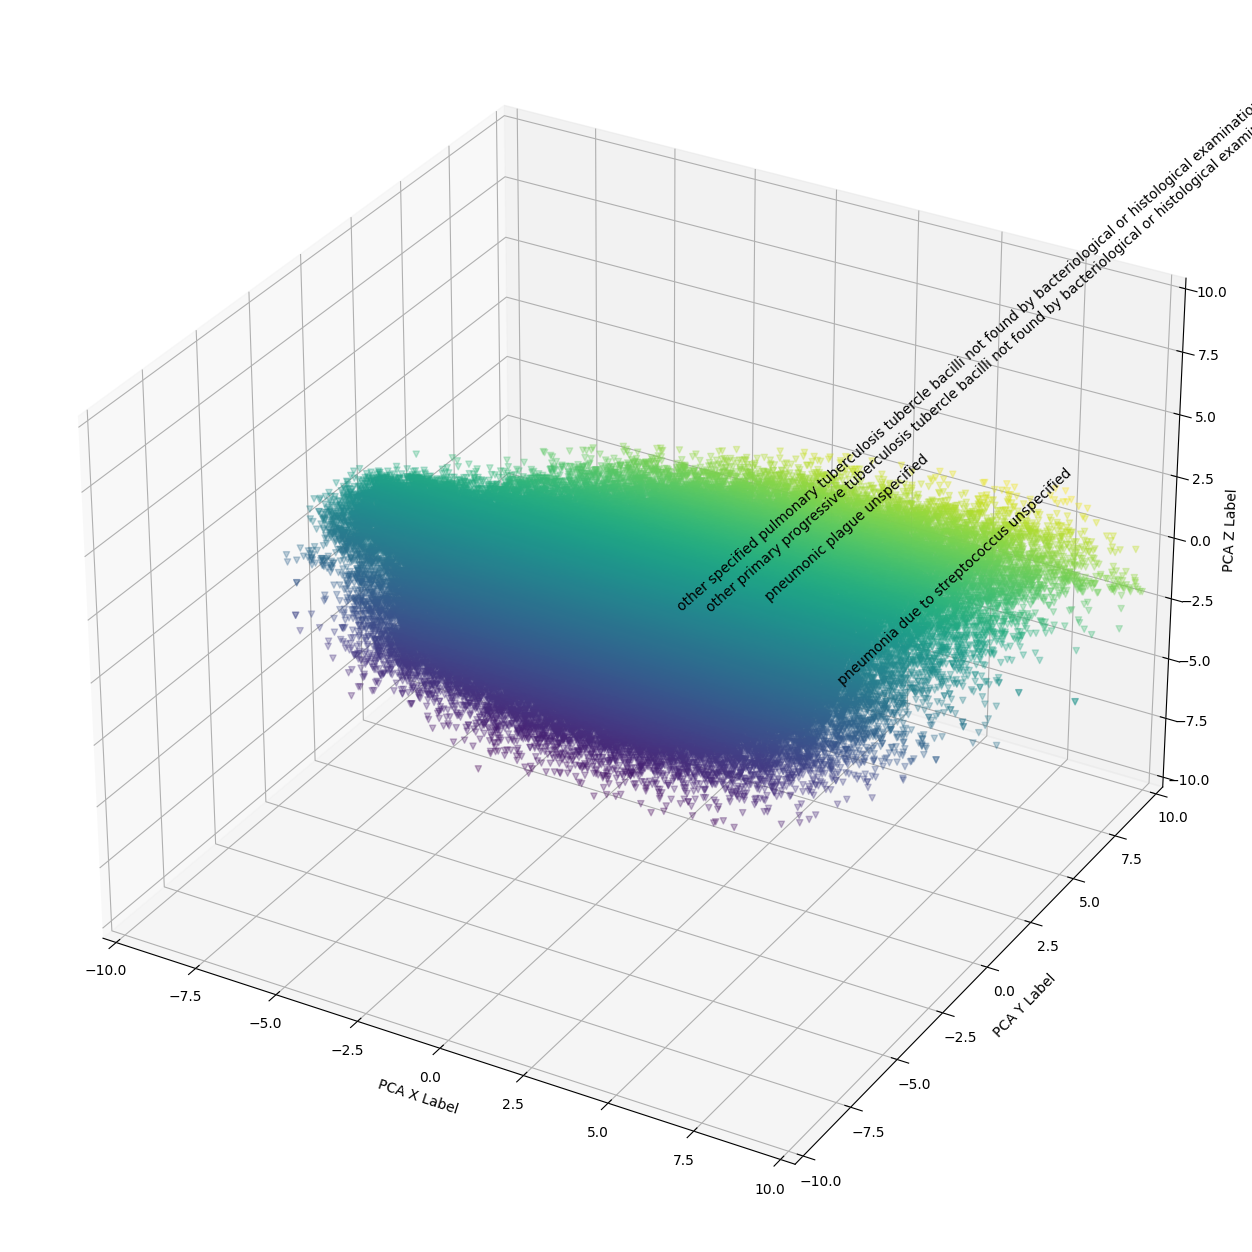

In [ ]:
vectors = embeddings
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = index.knnQuery(embeddings[100], k=2)
label_ids += [idx for idx in ids]
ids,_ = index.knnQuery(embeddings[505], k=2)
label_ids += [idx for idx in ids]
label_texts += [keywords[idx].lower() for idx in label_ids]
markers = ['v']*len(vectors)

components = pd.DataFrame({
    'x': pca_data[:,0],
    'y': pca_data[:,1],
    'z': pca_data[:,2]
})

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    components['x'].values,
    components['y'].values,
    c=components['y'].values,
    marker='v',
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components['x'][i]
    y = components['y'][i]
    z = components['z'][i]
    zdir = 'y'
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('PCA X Label')
ax.set_ylabel('PCA Y Label')
ax.set_zlabel('PCA Z Label')
plt.show()